In [1]:
import pandas as pd
import geopandas as gpd
import shapely.geometry
from shapely import wkt
import fiona
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_rows', 500)

https://hub.arcgis.com/datasets/6996f03a1b364dbab4008d99380370ed_0/explore?location=0.969507%2C1.535162%2C1.73

In [24]:
world = gpd.read_file("data/World_Cities.geojson")

In [25]:
pop = pd.read_csv("processed/World_Cities_updated_0.3_Ezra.csv")[["FID","POP_updated","POP_updated_year"]]

In [26]:
# Convert the columns to integers while handling NaN values appropriately
pop['POP_updated'] = pd.to_numeric(pop['POP_updated'], errors='coerce').astype('Int64')  # 'Int64' allows for NaN in integer columns
pop['POP_updated_year'] = pd.to_numeric(pop['POP_updated_year'], errors='coerce').astype('Int64')

In [27]:
pop

,FID,POP_updated,POP_updated_year
0,1,650877,2022
1,2,2817381,2022
2,3,1555626,2021
3,4,916001,2021
4,5,127437,2021
...,...,...,...
2535,2536,8320,2022
2536,2537,377900,2022
2537,2538,102400,2022
2538,2539,49800,2022


In [28]:
world = world.merge(pop, on="FID", how="left")

In [29]:
world['capital'] = world['STATUS'].apply(lambda x: 1 if 'national' in x.lower() else 0)

In [30]:
world.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [31]:
layers = fiona.listlayers("data/World_Water_Bodies/v107/hydropolys.gdb")

In [22]:
layers

['hydropolys']

https://hub.arcgis.com/content/e750071279bf450cbd510454a80f2e63/about

In [23]:
water = gpd.read_file("data/World_Water_Bodies/v107/hydropolys.gdb", layer="hydropolys")

In [32]:
water.head()

,Name1,Name2,Name3,TYPE,ISO_CC,SHAPE_Length,SHAPE_Area,geometry
0,,,,Inland intermittent,,0.084017,0.000161,"MULTIPOLYGON (((33.36209 -3.57682, 33.36398 -3..."
1,,,,Inland intermittent,,0.122991,0.000206,"MULTIPOLYGON (((13.74117 5.63882, 13.74251 5.6..."
2,,,,Inland intermittent,,0.039491,0.000059,"MULTIPOLYGON (((35.91590 13.69591, 35.91485 13..."
3,,,,Inland intermittent,,0.109760,0.000323,"MULTIPOLYGON (((-9.91448 15.94434, -9.91341 15..."
4,,,,Inland intermittent,AE,0.014541,0.000012,"MULTIPOLYGON (((53.83962 23.96135, 53.83979 23..."


In [33]:
water.TYPE.unique()

array(['Inland intermittent', 'Dry salt flat', 'Inland perennial',
       'Inundated area', 'Ocean or Sea'], dtype=object)

In [34]:
len(water)

2804476

In [35]:
# reproject to a projected CRS for distance calculations
projected_crs = 'EPSG:3857'  # Web Mercator projection
world = world.to_crs(projected_crs)
water = water.to_crs(projected_crs)

In [36]:
sea = water[water.TYPE=="Ocean or Sea"]

In [37]:
sea

,Name1,Name2,Name3,TYPE,ISO_CC,SHAPE_Length,SHAPE_Area,geometry
2259631,Indian Ocean,,,Ocean or Sea,,1.054688,0.061798,"MULTIPOLYGON (((6966165.010 -4877301.695, 6927..."
2259632,Indian Ocean,,,Ocean or Sea,,1.054688,0.061798,"MULTIPOLYGON (((6966165.010 -4851761.271, 6927..."
2259633,Indian Ocean,,,Ocean or Sea,,1.054688,0.061798,"MULTIPOLYGON (((6966165.010 -4826286.285, 6927..."
2259634,Indian Ocean,,,Ocean or Sea,,1.054688,0.061798,"MULTIPOLYGON (((6966165.010 -4800876.165, 6927..."
2259635,Indian Ocean,,,Ocean or Sea,,1.054688,0.061798,"MULTIPOLYGON (((6966165.010 -4980129.435, 6927..."
...,...,...,...,...,...,...,...,...
2804471,Caribbean Sea,Atlantic Ocean,,Ocean or Sea,,1.403653,0.053397,"MULTIPOLYGON (((-9627396.587 2403060.791, -965..."
2804472,Chukchi Sea,Arctic Ocean,,Ocean or Sea,,8.718282,0.324807,"MULTIPOLYGON (((-19663246.045 11598683.756, -1..."
2804473,Arctic Ocean,,,Ocean or Sea,,18.096119,16.604523,"MULTIPOLYGON (((-19480910.889 11825048.646, -1..."
2804474,Pacific Ocean,,,Ocean or Sea,,0.997544,0.020219,"MULTIPOLYGON (((20034568.967 -1866133.486, 200..."


In [38]:
# the nearest spatial join: https://geopandas.org/en/stable/docs/reference/api/geopandas.sjoin_nearest.html
nearest = gpd.sjoin_nearest(world, water, how='inner', lsuffix='_city', rsuffix='_water', distance_col='distance_water')

In [39]:
nearest = gpd.sjoin_nearest(nearest, sea[['Name1','Name2','Name3','TYPE','ISO_CC','SHAPE_Length','SHAPE_Area','geometry']], how='inner', lsuffix='_waterbody', rsuffix='_sea', distance_col='distance_sea')

In [40]:
nearest.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 2542 entries, 0 to 2539
Data columns (total 36 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   FID                      2542 non-null   int64   
 1   OBJECTID                 2542 non-null   int64   
 2   CITY_NAME                2542 non-null   object  
 3   GMI_ADMIN                2542 non-null   object  
 4   ADMIN_NAME               2542 non-null   object  
 5   FIPS_CNTRY               2542 non-null   object  
 6   CNTRY_NAME               2542 non-null   object  
 7   STATUS                   2542 non-null   object  
 8   POP                      2542 non-null   int64   
 9   POP_RANK                 2542 non-null   int64   
 10  POP_CLASS                2542 non-null   object  
 11  PORT_ID                  2542 non-null   int64   
 12  LABEL_FLAG               2542 non-null   int64   
 13  POP_SOURCE               2542 non-null   object  
 14  geome

In [41]:
water[water.Name1=="Lake Michigan"]

,Name1,Name2,Name3,TYPE,ISO_CC,SHAPE_Length,SHAPE_Area,geometry
2221773,Lake Michigan,,,Inland perennial,US,26.930234,6.226638,"MULTIPOLYGON (((-9507807.206 5796459.765, -950..."


In [42]:
nearest

,FID,OBJECTID,CITY_NAME,GMI_ADMIN,ADMIN_NAME,FIPS_CNTRY,CNTRY_NAME,STATUS,POP,POP_RANK,...,distance_water,index__sea,Name1__sea,Name2__sea,Name3__sea,TYPE__sea,ISO_CC__sea,SHAPE_Length__sea,SHAPE_Area__sea,distance_sea
0,1,1,Cuiaba,BRA-MGR,Mato Grosso,BR,Brazil,Provincial capital,540814,3,...,903.914063,2326476,Atlantic Ocean,,,Ocean or Sea,,1.064543,0.007229,1.420019e+06
1,2,2,Brasilia,BRA-DFD,Distrito Federal,BR,Brazil,National and provincial capital,2481272,2,...,4012.810793,2483520,Atlantic Ocean,,,Ocean or Sea,,1.040116,0.007083,9.292546e+05
2,3,3,Goiania,BRA-GOI,Goias,BR,Brazil,Provincial capital,1297154,2,...,15550.003073,2776415,Atlantic Ocean,,,Ocean or Sea,,0.422189,0.004244,9.069651e+05
3,4,4,Campo Grande,BRA-MGD,Mato Grosso do Sul,BR,Brazil,Provincial capital,776242,3,...,17118.757659,2326476,Atlantic Ocean,,,Ocean or Sea,,1.064543,0.007229,8.835995e+05
4,5,5,Pedro Juan Caballero,PRY-AMM,Amambay,PA,Paraguay,Provincial capital,0,0,...,14526.045735,2326476,Atlantic Ocean,,,Ocean or Sea,,1.064543,0.007229,8.529278e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2535,2536,2536,Greymouth,NZL-WST,Westland,NZ,New Zealand,Provincial capital,0,0,...,2525.251905,2448637,Tasman Sea,Pacific Ocean,,Ocean or Sea,,1.058717,0.057883,2.525252e+03
2536,2537,2537,Christchurch,NZL-CNT,Canterbury,NZ,New Zealand,Provincial capital,388500,4,...,6979.020064,2353820,Pacific Ocean,,,Ocean or Sea,,1.007334,0.041327,8.413012e+03
2537,2538,2538,Dunedin,NZL-OTG,Otago,NZ,New Zealand,Provincial capital,130700,5,...,3592.055812,2485728,Pacific Ocean,,,Ocean or Sea,,0.097013,0.000236,3.592056e+03
2538,2539,2539,Invercargill,NZL-STH,Southland,NZ,New Zealand,Provincial capital,0,0,...,3846.671324,2600085,Tasman Sea,Pacific Ocean,,Ocean or Sea,,1.497316,0.038836,3.846671e+03


In [43]:
# convert distances from meters to kilometers
nearest['distance_water'] = nearest['distance_water'] / 1000  # Convert to kilometers

In [44]:
# convert distances from meters to kilometers
nearest['distance_sea'] = nearest['distance_sea'] / 1000  # Convert to kilometers

In [45]:
df = nearest.drop(columns=['OBJECTID','PORT_ID','LABEL_FLAG'])

In [46]:
def rank_population(pop):
    if pd.isna(pop): 
        return 0
    elif pop >= 5000000:
        return 1
    elif 1000000 <= pop < 5000000:
        return 2
    elif 500000 <= pop < 1000000:
        return 3
    elif 250000 <= pop < 500000:
        return 4
    elif 100000 <= pop < 250000:
        return 5
    elif 50000 <= pop < 100000:
        return 6
    else:
        return 7

In [47]:
df['POP_updated'] = pd.to_numeric(df['POP_updated'], errors='coerce')
df['POP_rank_updated'] = df['POP_updated'].apply(rank_population)

In [48]:
df

,FID,CITY_NAME,GMI_ADMIN,ADMIN_NAME,FIPS_CNTRY,CNTRY_NAME,STATUS,POP,POP_RANK,POP_CLASS,...,index__sea,Name1__sea,Name2__sea,Name3__sea,TYPE__sea,ISO_CC__sea,SHAPE_Length__sea,SHAPE_Area__sea,distance_sea,POP_rank_updated
0,1,Cuiaba,BRA-MGR,Mato Grosso,BR,Brazil,Provincial capital,540814,3,"500,000 to 999,999",...,2326476,Atlantic Ocean,,,Ocean or Sea,,1.064543,0.007229,1420.018591,3
1,2,Brasilia,BRA-DFD,Distrito Federal,BR,Brazil,National and provincial capital,2481272,2,"1,000,000 to 4,999,999",...,2483520,Atlantic Ocean,,,Ocean or Sea,,1.040116,0.007083,929.254581,2
2,3,Goiania,BRA-GOI,Goias,BR,Brazil,Provincial capital,1297154,2,"1,000,000 to 4,999,999",...,2776415,Atlantic Ocean,,,Ocean or Sea,,0.422189,0.004244,906.965140,2
3,4,Campo Grande,BRA-MGD,Mato Grosso do Sul,BR,Brazil,Provincial capital,776242,3,"500,000 to 999,999",...,2326476,Atlantic Ocean,,,Ocean or Sea,,1.064543,0.007229,883.599543,3
4,5,Pedro Juan Caballero,PRY-AMM,Amambay,PA,Paraguay,Provincial capital,0,0,,...,2326476,Atlantic Ocean,,,Ocean or Sea,,1.064543,0.007229,852.927751,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2535,2536,Greymouth,NZL-WST,Westland,NZ,New Zealand,Provincial capital,0,0,,...,2448637,Tasman Sea,Pacific Ocean,,Ocean or Sea,,1.058717,0.057883,2.525252,7
2536,2537,Christchurch,NZL-CNT,Canterbury,NZ,New Zealand,Provincial capital,388500,4,"250,000 to 499,999",...,2353820,Pacific Ocean,,,Ocean or Sea,,1.007334,0.041327,8.413012,4
2537,2538,Dunedin,NZL-OTG,Otago,NZ,New Zealand,Provincial capital,130700,5,"100,000 to 249,999",...,2485728,Pacific Ocean,,,Ocean or Sea,,0.097013,0.000236,3.592056,5
2538,2539,Invercargill,NZL-STH,Southland,NZ,New Zealand,Provincial capital,0,0,,...,2600085,Tasman Sea,Pacific Ocean,,Ocean or Sea,,1.497316,0.038836,3.846671,7


In [49]:
df.POP_rank_updated.value_counts()

POP_rank_updated
7    591
5    487
6    329
4    327
0    252
3    251
2    248
1     57
Name: count, dtype: int64

In [50]:
# # to modify later - remove cities without population data and is not the capital 
df = df[~((df.capital==0)&(df.POP_rank_updated==0))] 

In [51]:
# define a mapping for POP_RANK to radius thresholds
thresholds = {
    1: 40, # 5,000,000 and greater
    2: 30, # 1,000,000 to 4,999,999
    3: 20, # 500,000 to 999,999
    4: 15, # 250,000 to 499,999
    5: 10, # 100,000 to 249,999
    6: 8, # 50,000 to 99,999
    7: 5, # Less than 50,000
    0: 5 #  no population data # row removed so the number does not matter
}

In [52]:
# Function to determine 'type' based on POP_RANK and distance to the sea/ocean
def determine_type(row):
    pop_rank = row['POP_rank_updated']
    distance = row['distance_sea']
    
    # Get the corresponding radius for the city's pop_rank
    threshold = thresholds.get(pop_rank)
    
    # Check if distance to coast is less than the threshold
    if distance < threshold:
        return 'coast'
    else:
        return 'inland'

In [53]:
df['city_type'] = df.apply(determine_type, axis=1)

/Users/mengcai/opt/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [54]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 2306 entries, 0 to 2539
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   FID                      2306 non-null   int64   
 1   CITY_NAME                2306 non-null   object  
 2   GMI_ADMIN                2306 non-null   object  
 3   ADMIN_NAME               2306 non-null   object  
 4   FIPS_CNTRY               2306 non-null   object  
 5   CNTRY_NAME               2306 non-null   object  
 6   STATUS                   2306 non-null   object  
 7   POP                      2306 non-null   int64   
 8   POP_RANK                 2306 non-null   int64   
 9   POP_CLASS                2306 non-null   object  
 10  POP_SOURCE               2306 non-null   object  
 11  geometry                 2306 non-null   geometry
 12  POP_updated              2290 non-null   Int64   
 13  POP_updated_year         2284 non-null   Int64   
 14  capit

In [55]:
# df[df['FIPS_CNTRY']=="CA"] # Canada is all water
us = df[df['FIPS_CNTRY']=="US"] 

In [56]:
us[us.CITY_NAME=="Chicago"]

,FID,CITY_NAME,GMI_ADMIN,ADMIN_NAME,FIPS_CNTRY,CNTRY_NAME,STATUS,POP,POP_RANK,POP_CLASS,...,Name1__sea,Name2__sea,Name3__sea,TYPE__sea,ISO_CC__sea,SHAPE_Length__sea,SHAPE_Area__sea,distance_sea,POP_rank_updated,city_type
495,496,Chicago,USA-ILL,Illinois,US,United States,Other,2693976,2,"1,000,000 to 4,999,999",...,Chesapeake Bay,Atlantic Ocean,,Ocean or Sea,,0.039096,0.000026,1243.559923,2,inland


In [57]:
us

,FID,CITY_NAME,GMI_ADMIN,ADMIN_NAME,FIPS_CNTRY,CNTRY_NAME,STATUS,POP,POP_RANK,POP_CLASS,...,Name1__sea,Name2__sea,Name3__sea,TYPE__sea,ISO_CC__sea,SHAPE_Length__sea,SHAPE_Area__sea,distance_sea,POP_rank_updated,city_type
171,172,Galveston,USA-TEX,Texas,US,United States,Other,50446,6,"50,000 to 99,999",...,Gulf of Mexico,Atlantic Ocean,,Ocean or Sea,,0.723591,0.006020,0.000000,5,coast
173,174,Juneau,USA-ALK,Alaska,US,United States,Provincial capital,31974,7,"Less than 50,000",...,Pacific Ocean,,,Ocean or Sea,,1.008181,0.003910,1.023836,7,coast
174,175,Jackson,USA-MSP,Mississippi,US,United States,Provincial capital,4642,7,"Less than 50,000",...,Gulf of Mexico,Atlantic Ocean,,Ocean or Sea,,0.307473,0.003071,271.127780,5,inland
175,176,Baton Rouge,USA-LOU,Louisiana,US,United States,Provincial capital,220236,5,"100,000 to 249,999",...,Gulf of Mexico,Atlantic Ocean,,Ocean or Sea,,0.408333,0.005380,104.392427,3,inland
176,177,New Orleans,USA-LOU,Louisiana,US,United States,Other,390144,4,"250,000 to 499,999",...,Gulf of Mexico,Atlantic Ocean,,Ocean or Sea,,1.172195,0.026947,20.573205,3,inland
177,178,Houston,USA-TEX,Texas,US,United States,Other,2320268,2,"1,000,000 to 4,999,999",...,Gulf of Mexico,Atlantic Ocean,,Ocean or Sea,,1.055011,0.013106,44.113235,1,inland
178,179,Fairbanks,USA-ALK,Alaska,US,United States,Other,30917,7,"Less than 50,000",...,Pacific Ocean,,,Ocean or Sea,,10.437361,0.648025,853.501222,6,inland
179,180,Nome,USA-ALK,Alaska,US,United States,Other,3870,7,"Less than 50,000",...,Bering Sea,Pacific Ocean,,Ocean or Sea,,8.083454,0.710220,25.626093,7,inland
181,182,Seward,USA-ALK,Alaska,US,United States,Other,2796,7,"Less than 50,000",...,Pacific Ocean,,,Ocean or Sea,,0.629494,0.010937,1.376559,7,coast
182,183,Honolulu,USA-HAW,Hawaii,US,United States,Provincial capital,371657,4,"250,000 to 499,999",...,Pacific Ocean,,,Ocean or Sea,,1.804889,0.021876,2.288483,3,coast


<Axes: >

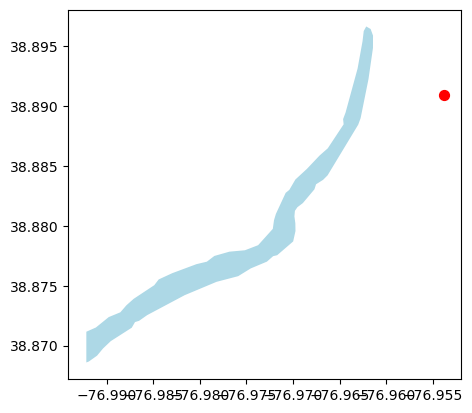

In [58]:
fig, ax = plt.subplots()
sea[sea.index==2487003].to_crs(epsg=4326).plot(ax=ax,color="lightblue")
us[us.capital==1].to_crs(epsg=4326).plot(ax=ax, color="red", marker="o", markersize=50)

In [59]:
df[df.city_type=="coast"]

,FID,CITY_NAME,GMI_ADMIN,ADMIN_NAME,FIPS_CNTRY,CNTRY_NAME,STATUS,POP,POP_RANK,POP_CLASS,...,Name1__sea,Name2__sea,Name3__sea,TYPE__sea,ISO_CC__sea,SHAPE_Length__sea,SHAPE_Area__sea,distance_sea,POP_rank_updated,city_type
15,16,Mata-Utu,WLF,Wallis & Futuna,WF,Wallis & Futuna,National and provincial capital,0,0,,...,Pacific Ocean,,,Ocean or Sea,,1.652176,0.055174,0.018889,7,coast
16,17,Apia,WSM,Samoa,WS,Samoa,National capital,37391,7,"Less than 50,000",...,Pacific Ocean,,,Ocean or Sea,,1.146609,0.045098,0.000000,7,coast
17,18,Pago Pago,ASM,American Samoa,AQ,American Samoa,National and provincial capital,3656,7,"Less than 50,000",...,Pacific Ocean,,,Ocean or Sea,,2.595805,0.050280,0.302533,7,coast
18,19,Papeete,PYF,French Polynesia,FP,French Polynesia,National and provincial capital,25763,7,"Less than 50,000",...,Pacific Ocean,,,Ocean or Sea,,1.182310,0.049963,0.052122,7,coast
19,20,Alofi,NIU,Niue,NE,Niue,National and provincial capital,639,7,"Less than 50,000",...,Pacific Ocean,,,Ocean or Sea,,1.181183,0.043316,0.826935,7,coast
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2534,2535,Nelson,NZL-NMR,Nelson-Marlborough,NZ,New Zealand,Provincial capital,0,0,,...,Tasman Sea,Pacific Ocean,,Ocean or Sea,,1.990741,0.036365,2.627987,6,coast
2535,2536,Greymouth,NZL-WST,Westland,NZ,New Zealand,Provincial capital,0,0,,...,Tasman Sea,Pacific Ocean,,Ocean or Sea,,1.058717,0.057883,2.525252,7,coast
2536,2537,Christchurch,NZL-CNT,Canterbury,NZ,New Zealand,Provincial capital,388500,4,"250,000 to 499,999",...,Pacific Ocean,,,Ocean or Sea,,1.007334,0.041327,8.413012,4,coast
2537,2538,Dunedin,NZL-OTG,Otago,NZ,New Zealand,Provincial capital,130700,5,"100,000 to 249,999",...,Pacific Ocean,,,Ocean or Sea,,0.097013,0.000236,3.592056,5,coast


In [60]:
result_rows = []

for country_code, group in df.groupby('FIPS_CNTRY'):
    # Find the capital city in the group
    capital_cities = group[group['capital']==1]
    
    if capital_cities.empty:
        continue  # No capital city in this country

    # Assuming there is only one capital city per country
    capital_city = capital_cities.iloc[0]

    capital_type = capital_city['city_type']

    # Determine the type of city to find
    if capital_type == 'inland':
    # Need to find a coast city
        candidate_cities = group[group['city_type'] != 'inland']
    else: # sea
    # Need to find a inland city
        candidate_cities = group[group['city_type'] == 'inland']
       
    # Exclude the capital city from candidate cities
    candidate_cities = candidate_cities[candidate_cities['CITY_NAME'] != capital_city['CITY_NAME']]

    if candidate_cities.empty:
        # No suitable second city, just keep the capital city
        result_rows.append(capital_city)
    else:
        # Find the city with the closest population to the capital
        candidate_cities = candidate_cities.copy()
        candidate_cities['pop_diff'] = (candidate_cities['POP'] - capital_city['POP']).abs()

        # Get the city with the smallest population difference
        second_city = candidate_cities.loc[candidate_cities['pop_diff'].idxmin()]

        # Append both capital city and second city
        result_rows.extend([capital_city, second_city])

# Create the result dataframe
result = gpd.GeoDataFrame(result_rows, crs=projected_crs)

In [61]:
result

,FID,CITY_NAME,GMI_ADMIN,ADMIN_NAME,FIPS_CNTRY,CNTRY_NAME,STATUS,POP,POP_RANK,POP_CLASS,...,Name2__sea,Name3__sea,TYPE__sea,ISO_CC__sea,SHAPE_Length__sea,SHAPE_Area__sea,distance_sea,POP_rank_updated,city_type,pop_diff
295,296,Oranjestad,ABW,Aruba,AA,Aruba,National and provincial capital,28295,7,"Less than 50,000",...,Atlantic Ocean,,Ocean or Sea,,1.283472,0.053652,1.449000,6,coast,NaN
1555,1556,Saint John's,ATG,Antigua & Barbuda,AC,Antigua & Barbuda,National capital,0,0,,...,Atlantic Ocean,,Ocean or Sea,,1.896968,0.045993,0.684450,7,coast,NaN
2256,2257,Abu Dhabi,ARE-AZA,Abu Zaby,AE,United Arab Emirates,National and provincial capital,1539000,2,"1,000,000 to 4,999,999",...,Indian Ocean,,Ocean or Sea,,3.565310,0.047519,2.347458,2,coast,NaN
1071,1072,Kabul,AFG-KAB,Kabol,AF,Afghanistan,National and provincial capital,4136000,2,"1,000,000 to 4,999,999",...,Indian Ocean,,Ocean or Sea,,0.702247,0.009304,1192.107975,2,inland,NaN
1909,1910,Algiers,DZA-ALG,Alger,AG,Algeria,National and provincial capital,3608000,2,"1,000,000 to 4,999,999",...,Atlantic Ocean,,Ocean or Sea,,1.359198,0.047538,1.553963,0,coast,NaN
1668,1669,Sidi-Bel-Abbes,DZA-SBA,Sidi bel Abbes,AG,Algeria,Provincial capital,0,0,,...,Atlantic Ocean,,Ocean or Sea,,0.944712,0.024975,69.961152,5,inland,3608000.0
2259,2260,Baku,AZE-BAK,Baku,AJ,Azerbaijan,National and provincial capital,2270030,2,"1,000,000 to 4,999,999",...,Indian Ocean,,Ocean or Sea,,1.232486,0.017702,1364.705622,2,inland,NaN
630,631,Tirana,ALB-TIR,Tirane,AL,Albania,National and provincial capital,418495,4,"250,000 to 499,999",...,Mediterranean Sea,Atlantic Ocean,Ocean or Sea,,0.705037,0.027471,36.166383,4,inland,NaN
604,605,Durres,ALB-DRR,Durres,AL,Albania,Provincial capital,113249,5,"100,000 to 249,999",...,Mediterranean Sea,Atlantic Ocean,Ocean or Sea,,0.705037,0.027471,1.825464,5,coast,305246.0
780,781,Yerevan,ARM,Armenia,AM,Armenia,National capital,1079732,2,"1,000,000 to 4,999,999",...,Atlantic Ocean,,Ocean or Sea,,1.065728,0.046926,1047.205463,2,inland,NaN


In [62]:
result.to_csv("400cities_20241108.csv", index=False)